# Homework 3 - balancing & binning (deadline 6. 1. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do:

  1. Download the dataset from the course pages (default_of_credit_card_clients.csv).
  1. Use binning (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other preprocessing techniques (your choice!) on the data set and comment the classification results.
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments on each step of your solution, with short explanations of your choices.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("default_of_credit_card_clients.csv", sep=';')

# Introduction
Since this is a well-known dataset of [customers' default payments in Taiwan](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) (described also [here](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)), I am going to use this apriori knowledge and transform this dataset a bit. 

In [3]:
columns = [
"LIMIT_BAL", 
"SEX", "EDUCATION", "MARRIAGE",
"AGE",
"PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
"BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
"PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
"CLASS"]
print(len(columns), len(data.columns))
data.columns = columns

24 24


## Categorical Features

In [4]:
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    data[col] = data[col].astype('category')

Now let's convert those categorical data

In [5]:
data = pd.get_dummies(data)

## Feature Addition

In [6]:
for col in ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]:
    print(np.sort(data[col].unique().tolist()))
    data[col + "_DULY"] = pd.Series(data[col] <= 0)

[-2 -1  0  1  2  3  4  5  6  7  8]
[-2 -1  0  1  2  3  4  5  6  7  8]
[-2 -1  0  1  2  3  4  5  6  7  8]
[-2 -1  0  1  2  3  4  5  6  7  8]
[-2 -1  0  2  3  4  5  6  7  8]
[-2 -1  0  2  3  4  5  6  7  8]


* These features represent "Repayment status". -1 means "paid duly". I am not sure how to handle -2 values, so I assume repayment was even sooner. 
* Therefore I created indicator features to represent soon payment ($\leq0$)

## Classes overview

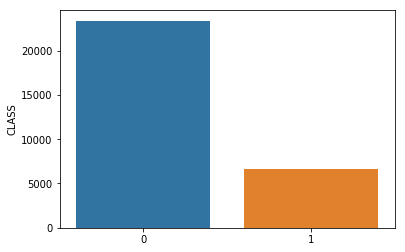

22.12% of CLASS 1


In [7]:
sns.barplot(data['CLASS'].value_counts().index, data['CLASS'].value_counts())
plt.show()
print(f"{data['CLASS'].mean()*100}% of CLASS 1")

We can clearly see, that the majority class is 0.

Now let's split the dataset into train and validation set 

**Note:** I have read some articles and answeres on SO about balancing, and everytime they say, I should balance *only* the training set.

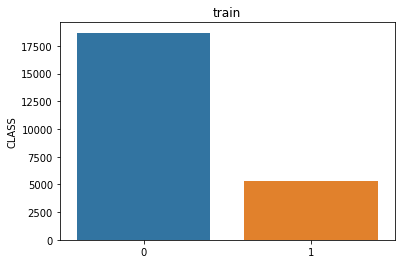

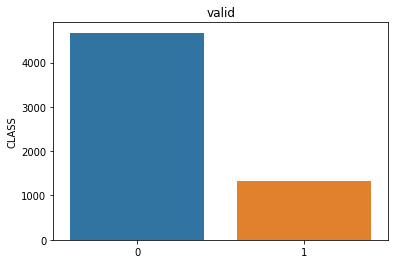

y_train: 22.120833333333334%, y_test: 22.116666666666667%


In [8]:
train_data, valid_data = train_test_split(data, test_size=.2, stratify=data.CLASS, random_state=42)

sns.barplot(train_data.CLASS.value_counts().index, train_data.CLASS.value_counts()).set_title('train')
plt.show()
sns.barplot(valid_data.CLASS.value_counts().index, valid_data.CLASS.value_counts()).set_title('valid')
plt.show()

print(f"y_train: {train_data.CLASS.mean()*100}%, y_test: {valid_data.CLASS.mean()*100}%")

# Classification on unbalanced (preprocessed) data

* I am going to use Gaussian Naive Bayes, SVM with RBF kernel, Neural Network, K-Nearest Neighbors and Logistic Regression as classification models.
* On train set I will do a small **grid-search** for best parameters, which will be provided by **stratified** (default in GridSearchCV selector) **3-fold cross-validation**.
* Then I will choose the **best estimator**, fitted with training data and predict the validation data.
* In the end you will see **ROC curve** and **Precision-Recall curve**, with the average AUC-ROC and Precission for each model.

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, get_scorer, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import plot_roc_curve

In [10]:
def models_pipeline(data_train, data_val, verbose=False, scale=True, pca=None, data_name="unbalanced"):
    X_train = data_train.drop(columns=["CLASS"])
    y_train = data_train.CLASS
    
    X_val = data_val.drop(columns=["CLASS"])
    y_val = data_val.CLASS
    
    classifiers = [
        ("Naive Bayes", GaussianNB(), {'priors': [[1 - y_train.mean(), y_train.mean()]]}),
        ("RBF SVM", SVC(probability=True), {'kernel': ['rbf'], 'C': [1, 5]}),
        ("Random Forest", RandomForestClassifier(n_jobs=-1, random_state=42), {'n_estimators': [100, 300]}),
        ("Neural Net", MLPClassifier(), {'learning_rate_init': [0.001, 0.0001], 'max_iter': [300]}),
        ("K-NN", KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [3, 5, 10]}),
        ("Log Reg", LogisticRegression(n_jobs=-1), {'C': [1, 5, 10]})
    ]

    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
#     print(X_train.shape)
    if pca is not None and (pca < 1 and pca > 0):
        p = PCA(int(X_train.shape[1]*pca))
        p.fit(X_train)
        X_train = p.transform(X_train)
        X_val = p.transform(X_val)
    
#     print(X_train.shape)
    figure = plt.figure(figsize=(3, 3))
    sns.barplot(y_train.value_counts().index, y_train.value_counts()).set_title('train set class')
    plt.show()
    
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    results = []
    for name, clf, param in classifiers:
        gscv = GridSearchCV(clf, param_grid=param, scoring=get_scorer('roc_auc'), n_jobs=-1, cv=3)
        gscv.fit(X_train, y_train)
    #     mean_test_ROC = gscv.cv_results_['mean_test_score']
        best_score = gscv.best_score_
        best_estimator = gscv.best_estimator_
        print(f"{name} done. ", end="")
        
        y_val_score = best_estimator.predict_proba(X_val).T[1]
        
        auc_roc = roc_auc_score(y_val, y_val_score)
        fpr, tpr, thresholds = roc_curve(y_val, y_val_score)
        axes[0].plot(fpr, tpr, label=f"AUC = {auc_roc:0.3f}, "+name)
    
        avg_precision = average_precision_score(y_val, y_val_score)
        precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_score)
    
        axes[1].plot(precision, recall, label=f"P = {avg_precision:.3f}, "+name)
        
        res = {"name": name, "ROC_"+data_name: auc_roc, "P_"+data_name: avg_precision}
        results.append(res)
        
    print() 
    axes[0].set(title='ROC curve of models on validation set', xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[1].set(title='Precision(P)-Recall curve', xlabel='Precision', ylabel='Recall')
    axes[0].legend(loc='lower right')
    axes[1].legend()
    plt.show()
    r = pd.DataFrame(results).set_index('name')
    return r

* First, let's run it on unbalanced data, with PCA taking 2/3 * n_features as number of components. 

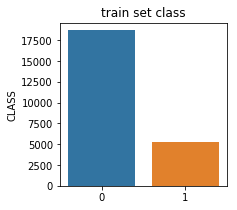

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. K-NN done. Log Reg done. 


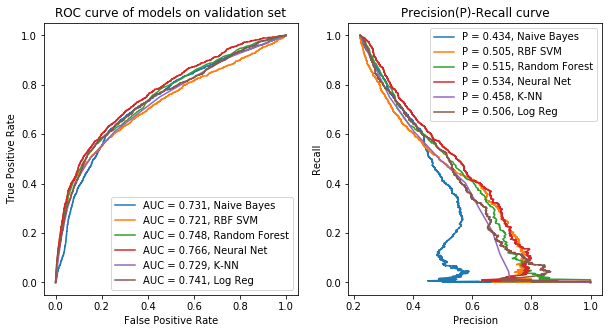

P_unbalanced  ROC_unbalanced
name                                       
Naive Bayes        0.434109        0.731373
RBF SVM            0.505074        0.720788
Random Forest      0.514746        0.747997
Neural Net         0.533694        0.766496
K-NN               0.457924        0.729072
Log Reg            0.506223        0.741280

In [11]:
models_pipeline(train_data, valid_data, pca=(2/3))

* We can see, that Neural Net is the leader in both ROC and P-R metrics. I set it to 300 iterations, si it is (over)fitting very well.
* The table on the bottom shows us best ROC on training set (mean from all folds of best estimator), which is almost the same as on validation set. I think this is the unbalanceness, which is causing it.

# Balancing

* I use Random Under Samper, Tomek Links and Edited Nearest Neighbors for under-sampling; SMOTE for up-sampling and SMOTEEN for combined approach.
* I let my classification pipeline gather both metrics and plot them for each of the sampler.

(24000, 40)
unbalanced
(24000, 40)


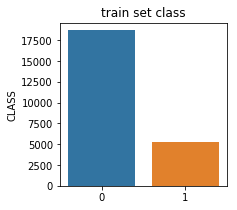

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. K-NN done. Log Reg done. 


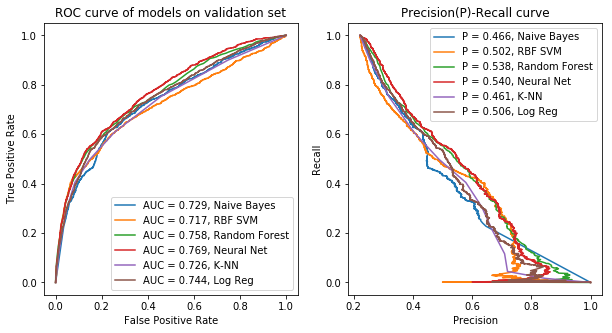

(24000, 40)
Random under-sampling
class 1: 50.0%
(10618, 40)


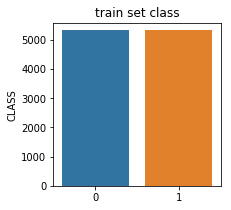

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


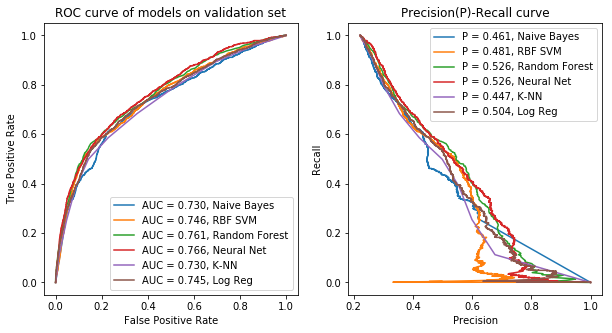

(24000, 40)
Tomek Links
class 1: 23.540105529197888%
(22553, 40)


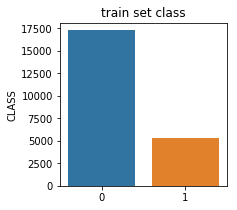

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


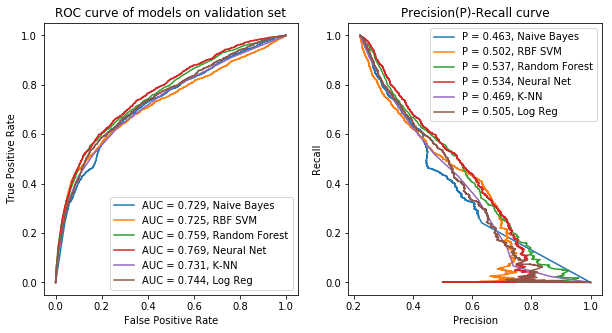

(24000, 40)
ENN
class 1: 34.16344916344916%
(15540, 40)


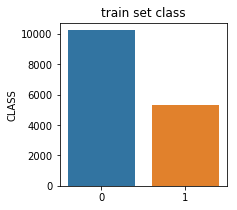

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


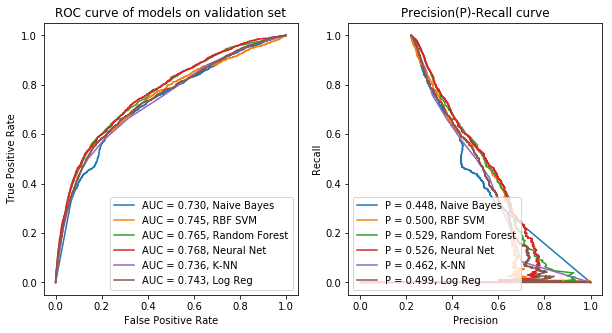

(24000, 40)
SMOTE
class 1: 50.0%
(37382, 40)


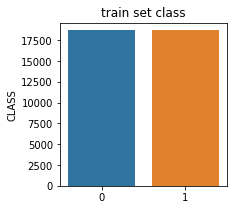

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


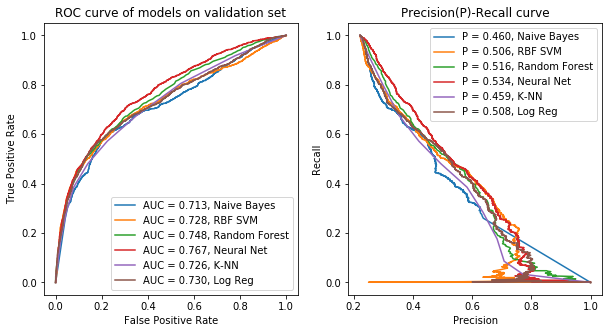

(24000, 40)
SMOTEENN
class 1: 62.53817750831928%
(21937, 40)


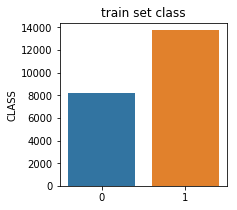

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


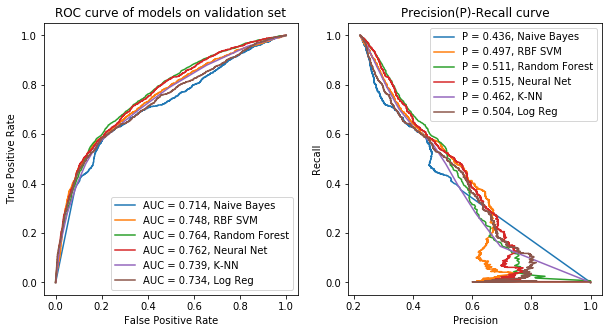

P_unbalanced  ROC_unbalanced  P_Random under-sampling  \
name                                                                   
Naive Bayes        0.465800        0.729362                 0.460649   
RBF SVM            0.501745        0.716872                 0.481424   
Random Forest      0.538078        0.758068                 0.525579   
Neural Net         0.539516        0.769151                 0.525911   
K-NN               0.461190        0.726021                 0.447102   
Log Reg            0.505728        0.743571                 0.503835   

               ROC_Random under-sampling  P_Tomek Links  ROC_Tomek Links  \
name                                                                       
Naive Bayes                     0.730015       0.462541         0.729399   
RBF SVM                         0.745880       0.502495         0.724996   
Random Forest                   0.761159       0.537386         0.759462   
Neural Net                      0.766124       0.534264         0.768844   
K-NN                            0.730351       0.468851         0.731080   
Log Reg                         0.744827       0.505091         0.743623   

                  P_ENN   ROC_ENN   P_SMOTE  ROC_SMOTE  P_SMOTEENN  \
name                                                                 
Naive Bayes    0.447823  0.729616  0.459873   0.712968    0.436287   
RBF SVM        0.500265  0.744956  0.506485   0.727604    0.496896   
Random Forest  0.528873  0.764543  0.515863   0.748331    0.511136   
Neural Net     0.525891  0.767683  0.533969   0.767375    0.515258   
K-NN           0.462391  0.736395  0.459308   0.725756    0.461955   
Log Reg        0.498940  0.743374  0.508096   0.730282    0.503913   

               ROC_SMOTEENN  
name                         
Naive Bayes        0.713980  
RBF SVM            0.748476  
Random Forest      0.764156  
Neural Net         0.762043  
K-NN               0.738953  
Log Reg            0.733872

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


resamplers = [
    (None, 'unbalanced'),
    (RandomUnderSampler(random_state=42),'Random under-sampling'),
    (TomekLinks(),'Tomek Links'),
    (EditedNearestNeighbours(),'ENN'),
    (SMOTE(random_state=42),'SMOTE'),
    (SMOTEENN(random_state=42),'SMOTEENN'),
]

# models_pipeline(train_data, valid_data)

results = pd.DataFrame()

for resampler, description in resamplers:
    X_res = train_data.copy()
    y_res = train_data.copy()
    print(X_res.shape)
    print(description)
    if resampler is not None:
        X_res = train_data.drop(columns=['CLASS'])
        y_res = train_data.CLASS
        X_res, y_res = resampler.fit_sample(X_res, y_res)

        X_res = pd.DataFrame(X_res)
        X_res['CLASS'] = y_res
        print(f"class 1: {y_res.mean()*100}%")
    
    print(X_res.shape)
    
    
    results = pd.concat([results, models_pipeline(X_res, valid_data, data_name=description)], axis=1)
results

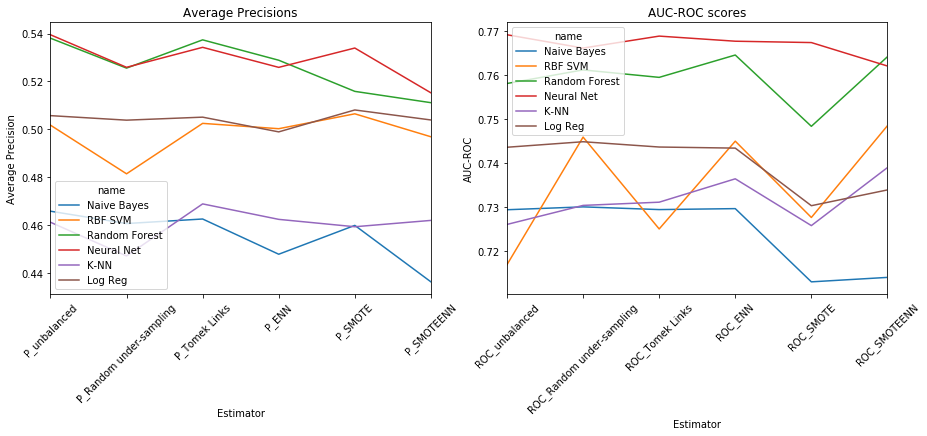

In [13]:
def plot_results(results):
    prec = results.filter(regex=("^P"))
    roc = results.filter(regex=("^ROC"))
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    prec.T.plot(ax=axes[0], title='Average Precisions')
    axes[0].set(xlabel='Estimator', ylabel='Average Precision')
    roc.T.plot(ax=axes[1], title='AUC-ROC scores')
    axes[1].set(xlabel='Estimator', ylabel='AUC-ROC')
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(45)
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(45)
    plt.show()
plot_results(results)

* Neural network nand Random Forest are the leaders. They seem to be pretty stable, but surprisingly - they are working the best on unbalanced data. 
* SVM seems to be prone to sampling, works better on under-sampled training set.

# Binning
* Studied [here](https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b).
* I will skip __Fixed-Width Binning__, since it is not so data-driven, as Adaptive Binning.

Let's take a look again, at unique values in our data:

In [14]:
df = data.copy()
data.nunique()

LIMIT_BAL         81
AGE               56
PAY_0             11
PAY_2             11
PAY_3             11
PAY_4             11
PAY_5             10
PAY_6             10
BILL_AMT1      22723
BILL_AMT2      22346
BILL_AMT3      22026
BILL_AMT4      21548
BILL_AMT5      21010
BILL_AMT6      20604
PAY_AMT1        7943
PAY_AMT2        7899
PAY_AMT3        7518
PAY_AMT4        6937
PAY_AMT5        6897
PAY_AMT6        6939
CLASS              2
SEX_1              2
SEX_2              2
EDUCATION_0        2
EDUCATION_1        2
EDUCATION_2        2
EDUCATION_3        2
EDUCATION_4        2
EDUCATION_5        2
EDUCATION_6        2
MARRIAGE_0         2
MARRIAGE_1         2
MARRIAGE_2         2
MARRIAGE_3         2
PAY_0_DULY         2
PAY_2_DULY         2
PAY_3_DULY         2
PAY_4_DULY         2
PAY_5_DULY         2
PAY_6_DULY         2
dtype: int64

* First I will take a look on AGE feature. It is already a discrete variable, so binning (categorizing) this feature would be sm-oo-th (haha, binning in practice).
* Let's take a look on a histogram, describing the distribution of this feature.

Text(0, 0.5, 'Frequency')

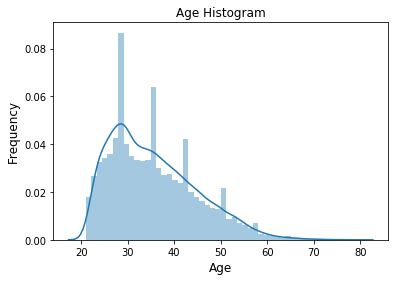

In [15]:
fig, ax = plt.subplots()
# data['AGE'].hist(edgecolor='black', grid=False)
sns.distplot(data.AGE)
ax.set_title('Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

* Expected normal distribution is right skewed (since not many people at age <21 deal with money and mortgages so much).
* Surprising are those peaks around 30th, 35th, 40th and 50th year, but I will not discuss it.

We will divide age into 4 equal "bins" - quartiles, by looking at the quantiles of the data.

In [16]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = data['AGE'].quantile(quantile_list)
quantiles

0.00    21.0
0.25    28.0
0.50    34.0
0.75    41.0
1.00    79.0
Name: AGE, dtype: float64

Now let's take a look, how well it slices the data:

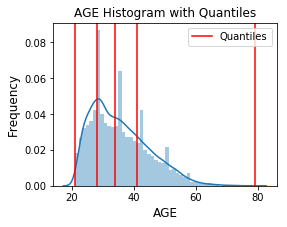

In [17]:
def quant_hist(col):
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = data[col].quantile(quantile_list)

    fig, ax = plt.subplots(figsize=(4,3))
    sns.distplot(data[col])
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title(col+' Histogram with Quantiles', 
                 fontsize=12)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
quant_hist('AGE')

This looks nice, therefore I am going to create a new feature - indicator of the quartile range, where given age belongs.

__Note:__ I am going to name it in order, since this categorical value is ordinal and I will treat it as any other discrete feature.

In [18]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
quantile_labels = [1, 2, 3, 4]
data['AGE_Q'] = pd.qcut(data['AGE'], q=quantile_list, labels=quantile_labels)

data[['AGE', 'AGE_Q']].iloc[4:9]

AGE AGE_Q
4   57     4
5   37     3
6   29     2
7   23     1
8   28     1

Works like a charm.

How about other continuous variables?

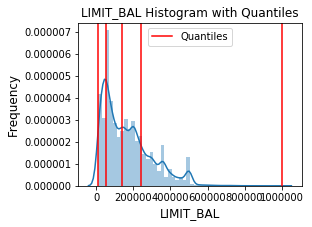

In [19]:
quant_hist('LIMIT_BAL')

Looks also plausible for this conversion, so again I am going to create a new ordinal feature.

In [20]:
data['LIMIT_BAL_Q'] = pd.qcut(data['LIMIT_BAL'], q=quantile_list, labels=quantile_labels)
data[['LIMIT_BAL', 'LIMIT_BAL_Q']].iloc[4:9]

LIMIT_BAL LIMIT_BAL_Q
4      50000           1
5      50000           1
6     500000           4
7     100000           2
8     140000           2

Each feature `PAY_AMT[1-6]` contains lots of zeros, which pushes its mean and median closer to zero, even after making a logarithm of the feature:

In [21]:
def quant_hist_log(col):
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    
    log_col = np.log1p(data[col])
    log_mean = np.mean(log_col)
    
    log_col.hist(bins=30, ax=axes[0])
#     sns.distplot(log_col, ax=axes[0])
    
    axes[0].axvline(log_mean, color='r')
    axes[0].set_title(col+' Histogram after Log Transform')
    axes[0].set_xlabel(col+'(log scale)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].text(11.5, 450, r'$\mu$='+str(log_mean), fontsize=10)
    
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = data[col].quantile(quantile_list)

    data[col].hist(bins=60)
    for quantile in quantiles:
        qvl = axes[1].axvline(quantile, color='r')
    axes[1].legend([qvl], ['Quantiles'], fontsize=10)
    axes[1].set_title(col+' Histogram with Quantiles', 
                 fontsize=12)
    axes[1].set_xlabel(col, fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)

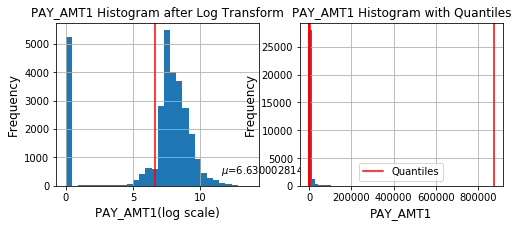

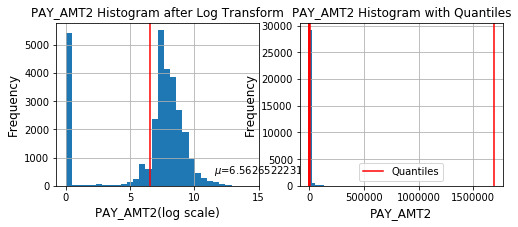

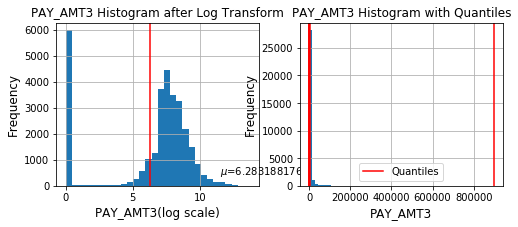

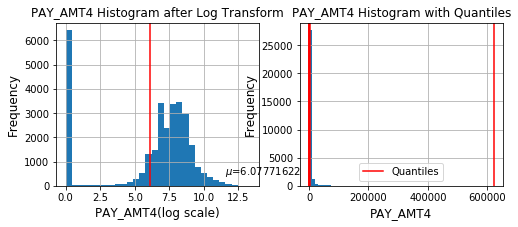

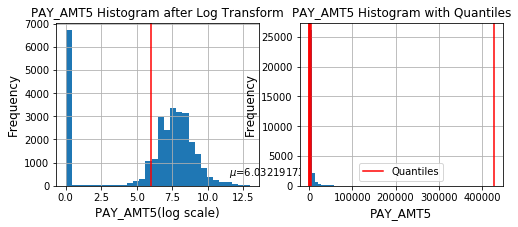

In [22]:
for n in range(1, 6):
    quant_hist_log('PAY_AMT'+str(n))

Hence using quantiles would not be appropriate. Using indicator of zero value would be appropriate.

I can imagine these solutions:
* Take only non-zero entries and divide them into quantiles
* Take only non-zero entries and divide it only by its mean (yess)
* Ignore this problem and don't use binning on these features.

In [23]:
def log_mean_division(col, verbose=False):
    log_col = np.log(data[col])
    log_col[log_col == -np.inf] = 0
    log_mean = log_col[log_col != 0].mean()

    bin_ranges = [-np.inf, 0, log_mean, log_col.max()]
    bin_names = [0, 1, 2]
    if verbose:
        display(pd.concat([data[col], pd.Series(log_col), pd.cut(log_col, bins=bin_ranges), pd.cut(log_col, bins=bin_ranges, labels=bin_names)], axis=1).head(10))
    return pd.cut(log_col, bins=bin_ranges, labels=bin_names)

col = 'PAY_AMT1'
cutt = log_mean_division(col)

# pd.concat([pd.cut(log_col, bins=bin_ranges), pd.Series(log_col)], axis=1)

cutt.dtype

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


CategoricalDtype(categories=[0, 1, 2], ordered=True)

Looks fine. Let's add all of these features into the data.

In [24]:
for n in range(1, 6):
    col = 'PAY_AMT'+str(n)
    data['PAY_AMT'+str(n)+'_log_mean'] = log_mean_division(col)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 47 columns):
LIMIT_BAL            30000 non-null int64
AGE                  30000 non-null int64
PAY_0                30000 non-null int64
PAY_2                30000 non-null int64
PAY_3                30000 non-null int64
PAY_4                30000 non-null int64
PAY_5                30000 non-null int64
PAY_6                30000 non-null int64
BILL_AMT1            30000 non-null int64
BILL_AMT2            30000 non-null int64
BILL_AMT3            30000 non-null int64
BILL_AMT4            30000 non-null int64
BILL_AMT5            30000 non-null int64
BILL_AMT6            30000 non-null int64
PAY_AMT1             30000 non-null int64
PAY_AMT2             30000 non-null int64
PAY_AMT3             30000 non-null int64
PAY_AMT4             30000 non-null int64
PAY_AMT5             30000 non-null int64
PAY_AMT6             30000 non-null int64
CLASS                30000 non-null int64
SEX_1    

* Unfortunately, there are negative values in `BILL_AMT[1-6]` feature, so I will leave it as it is.

In [26]:
np.sum(data.BILL_AMT1 <=0)

2598

In [27]:
data[data == np.nan].sum()

LIMIT_BAL            0.0
AGE                  0.0
PAY_0                0.0
PAY_2                0.0
PAY_3                0.0
PAY_4                0.0
PAY_5                0.0
PAY_6                0.0
BILL_AMT1            0.0
BILL_AMT2            0.0
BILL_AMT3            0.0
BILL_AMT4            0.0
BILL_AMT5            0.0
BILL_AMT6            0.0
PAY_AMT1             0.0
PAY_AMT2             0.0
PAY_AMT3             0.0
PAY_AMT4             0.0
PAY_AMT5             0.0
PAY_AMT6             0.0
CLASS                0.0
SEX_1                0.0
SEX_2                0.0
EDUCATION_0          0.0
EDUCATION_1          0.0
EDUCATION_2          0.0
EDUCATION_3          0.0
EDUCATION_4          0.0
EDUCATION_5          0.0
EDUCATION_6          0.0
MARRIAGE_0           0.0
MARRIAGE_1           0.0
MARRIAGE_2           0.0
MARRIAGE_3           0.0
PAY_0_DULY           0.0
PAY_2_DULY           0.0
PAY_3_DULY           0.0
PAY_4_DULY           0.0
PAY_5_DULY           0.0
PAY_6_DULY           0.0


In [28]:
for col in data.select_dtypes('category').columns:
    data[col] = data[col].cat.codes

In [29]:
train_data, valid_data = train_test_split(data, test_size=.2, stratify=data.CLASS, random_state=42)

(24000, 47)
unbalanced
(24000, 47)


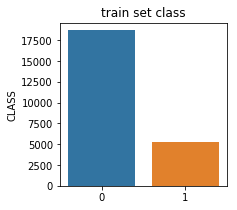

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


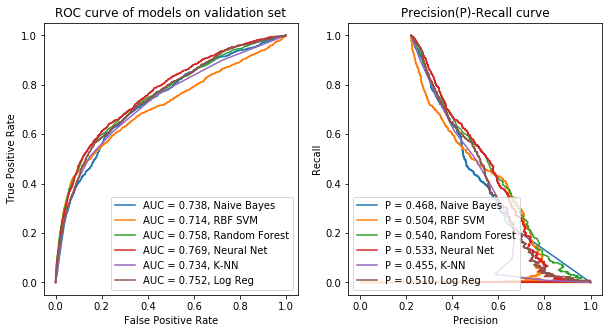

(24000, 47)
Random under-sampling
class 1: 50.0%
(10618, 47)


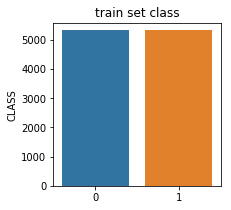

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


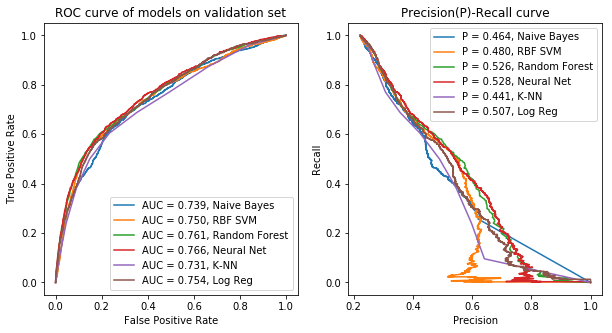

(24000, 47)
Tomek Links
class 1: 23.53801817778763%
(22555, 47)


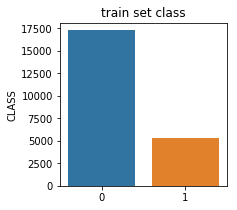

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


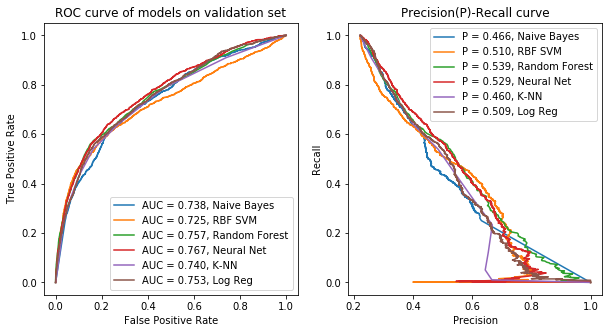

(24000, 47)
ENN
class 1: 34.16344916344916%
(15540, 47)


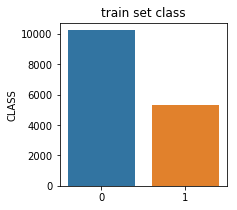

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


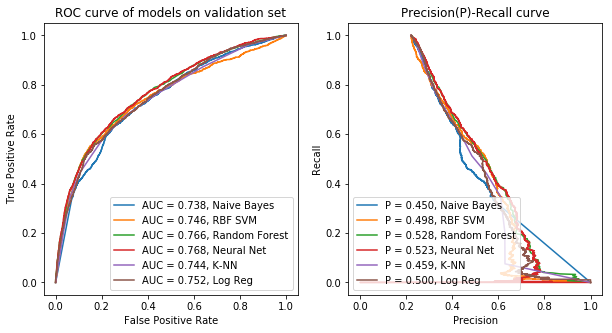

(24000, 47)
SMOTE
class 1: 50.0%
(37382, 47)


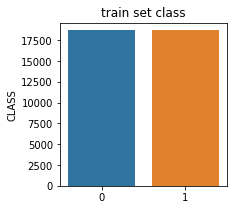

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


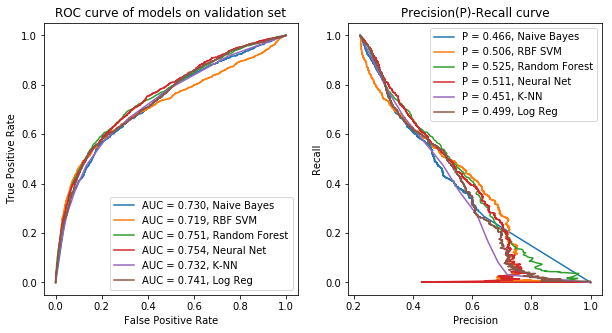

(24000, 47)
SMOTEENN
class 1: 62.541028446389504%
(21936, 47)


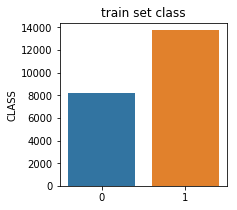

Naive Bayes done. RBF SVM done. Random Forest done. Neural Net done. 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-NN done. Log Reg done. 


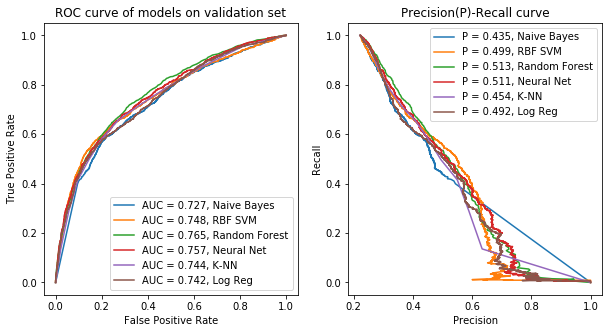

P_unbalanced  ROC_unbalanced  P_Random under-sampling  \
name                                                                   
Naive Bayes        0.465800        0.729362                 0.460649   
RBF SVM            0.501745        0.716872                 0.481424   
Random Forest      0.538078        0.758068                 0.525579   
Neural Net         0.539516        0.769151                 0.525911   
K-NN               0.461190        0.726021                 0.447102   
Log Reg            0.505728        0.743571                 0.503835   

               ROC_Random under-sampling  P_Tomek Links  ROC_Tomek Links  \
name                                                                       
Naive Bayes                     0.730015       0.462541         0.729399   
RBF SVM                         0.745880       0.502495         0.724996   
Random Forest                   0.761159       0.537386         0.759462   
Neural Net                      0.766124       0.534264         0.768844   
K-NN                            0.730351       0.468851         0.731080   
Log Reg                         0.744827       0.505091         0.743623   

                  P_ENN   ROC_ENN   P_SMOTE  ROC_SMOTE  P_SMOTEENN  \
name                                                                 
Naive Bayes    0.447823  0.729616  0.459873   0.712968    0.436287   
RBF SVM        0.500265  0.744956  0.506485   0.727604    0.496896   
Random Forest  0.528873  0.764543  0.515863   0.748331    0.511136   
Neural Net     0.525891  0.767683  0.533969   0.767375    0.515258   
K-NN           0.462391  0.736395  0.459308   0.725756    0.461955   
Log Reg        0.498940  0.743374  0.508096   0.730282    0.503913   

               ROC_SMOTEENN  P_SMOTEENN  ROC_SMOTEENN  
name                                                   
Naive Bayes        0.713980    0.434570      0.727383  
RBF SVM            0.748476    0.498675      0.748287  
Random Forest      0.764156    0.512515      0.764916  
Neural Net         0.762043    0.511157      0.756952  
K-NN               0.738953    0.453539      0.744142  
Log Reg            0.733872    0.491982      0.741910

In [30]:
resamplers = [
    (None, 'unbalanced'),
    (RandomUnderSampler(random_state=42),'Random under-sampling'),
    (TomekLinks(),'Tomek Links'),
    (EditedNearestNeighbours(),'ENN'),
    (SMOTE(random_state=42),'SMOTE'),
    (SMOTEENN(random_state=42),'SMOTEENN'),
]

results_bin = pd.DataFrame()

for resampler, description in resamplers:
    X_res = train_data.copy()
    y_res = train_data.copy()
    print(X_res.shape)
    print(description)
    if resampler is not None:
        X_res = train_data.drop(columns=['CLASS'])
        y_res = train_data.CLASS
        X_res, y_res = resampler.fit_sample(X_res, y_res)

        X_res = pd.DataFrame(X_res)
        X_res['CLASS'] = y_res
        print(f"class 1: {y_res.mean()*100}%")
    
    print(X_res.shape)
    
    
    results_bin = pd.concat([results, models_pipeline(X_res, valid_data, data_name=description)], axis=1)
results_bin

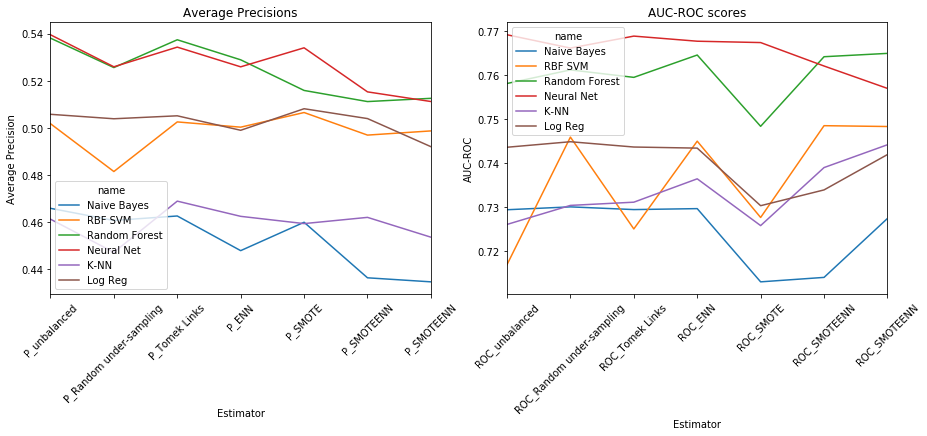

In [31]:
plot_results(results_bin)

* Binning helped SVM when SMOTEEN was used, however, this model is still not the best one in game for this dataset.
* Neural network likes a lot of data, therefore undersampling is causing a small fall in the results.


# Conclusion

* Use binning (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
    * I used binning on three types of features. On Age and Limit Amount I used quartile binning, on Pay Amount I used just 0 indicator and 2 quantiles (divided by mean without zero).
    
* Use at least 2 other preprocessing techniques (your choice!) on the data set and comment the classification results.
    * I used PCA, Scaling and dummy variables conversion, same as creating new features as indicators for soon payment. It seems it did not have much effect on the classification results.
* Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
    * I ran classification test on binned data (pretty much no change than on non-binned), Then I ran all models with cross-validation and grid-search on unbalanced data, random under-sampled, removed tomek-links, ENN under-sampling; SMOTE for up-sampling and SMOTEEN for combination. 
    * Results does not seem to vary. 
   
**Notes:** I used the same train/validation set for any result, to make it reproducible. The validation set remained unbalanced.